<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">  
# Project 3: Reddit NLP Classification

Project notebook organisation:<br>
[1 - Data Collection & Gathering](./Project_3.1_Data_Collection.ipynb)<br>
**2 - Data Cleaning & EDA** (current notebook)<br>
[3 - Modelling and Evaluation](./Project_3.3_Modelling_and_evaluation.ipynb)<br>

## Part 2: Data Cleaning & EDA

In [129]:
# Import libraries
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles
%matplotlib inline

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk import WordNetLemmatizer
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

## Import data

In [130]:
wsb = pd.read_csv('../data/wallstreetbets.csv')
stocks = pd.read_csv('../data/stocks.csv')

In [131]:
wsb.shape

(2000, 4)

In [132]:
stocks.shape

(2000, 4)

## Data Cleaning & Pre-processing
### Merge the two dataframes

In [133]:
df_combined = pd.concat([wsb, stocks],axis = 0, ignore_index = True)

In [134]:
df_combined

,subreddit,selftext,title,created_date
0,wallstreetbets,[removed],Let’s pick a stock and take it to the moon … w...,2022-08-07
1,wallstreetbets,[removed],If you can pick one stock (large cap) to inves...,2022-08-07
2,wallstreetbets,NaN,I fixed u/CollegeThrowaway___'s meme. It's mor...,2022-08-07
3,wallstreetbets,NaN,Anyone up for a four leaf ($CLOV) ER play? 🍀,2022-08-07
4,wallstreetbets,"Hi WSB guru,\n\nI tried asking this question i...",Anyone else holding AMC LEAP calls and what do...,2022-08-07
...,...,...,...,...
3995,stocks,[removed],"New to investing, Buy GOOGL?",2022-07-18
3996,stocks,[removed],"ETFs, What kind of taxation/regulation would w...",2022-07-18
3997,stocks,[removed],Consultation,2022-07-18
3998,stocks,[removed],Consultation regarding future career path,2022-07-18


### Imputation of missing data

In [135]:
df_combined.isnull().sum()

subreddit         0
selftext        980
title             0
created_date      0
dtype: int64

In [136]:
#Fill NA with blank
df_combined = df_combined.fillna('')

#Fill [removed] in selftext with blank
df_combined['selftext'] = df_combined['selftext'].replace('[removed]', '')

In [137]:
#Create a new column, combine title with self text
df_combined['combined_text'] = df_combined['title'] + df_combined['selftext']


In [138]:
#Get string length of combined text
df_combined['combined_text_length'] = df_combined['combined_text'].str.len()

#Get word count of combined text
df_combined['combined_text_count'] = df_combined['combined_text'].str.split().str.len()

In [139]:
#Get string length of title
df_combined['title_length'] = df_combined['title'].str.len()

#Get word count of title
df_combined['title_count'] = df_combined['title'].str.split().str.len()

In [140]:
#Drop the unnecessary columns
df_combined = df_combined.drop(['created_date'], axis = 1)

In [141]:
df_combined.isnull().sum()

subreddit               0
selftext                0
title                   0
combined_text           0
combined_text_length    0
combined_text_count     0
title_length            0
title_count             0
dtype: int64

In [142]:
df_combined.head()

,subreddit,selftext,title,combined_text,combined_text_length,combined_text_count,title_length,title_count
0,wallstreetbets,,Let’s pick a stock and take it to the moon … w...,Let’s pick a stock and take it to the moon … w...,67,15,67,15
1,wallstreetbets,,If you can pick one stock (large cap) to inves...,If you can pick one stock (large cap) to inves...,91,20,91,20
2,wallstreetbets,,I fixed u/CollegeThrowaway___'s meme. It's mor...,I fixed u/CollegeThrowaway___'s meme. It's mor...,61,8,61,8
3,wallstreetbets,,Anyone up for a four leaf ($CLOV) ER play? 🍀,Anyone up for a four leaf ($CLOV) ER play? 🍀,44,10,44,10
4,wallstreetbets,"Hi WSB guru,\n\nI tried asking this question i...",Anyone else holding AMC LEAP calls and what do...,Anyone else holding AMC LEAP calls and what do...,838,153,69,13


### Removal of duplicates based on title

In [143]:
df_combined[df_combined.duplicated(['title'], keep = False)].count()

subreddit               309
selftext                309
title                   309
combined_text           309
combined_text_length    309
combined_text_count     309
title_length            309
title_count             309
dtype: int64

In [144]:
df_combined.drop_duplicates(subset= ['title'], keep = 'first' , inplace = True)

### Map Wallstreetbets and Stocks to 1 and 0 respectively

In [145]:
df_combined['subreddit'] = df_combined['subreddit'].map({'wallstreetbets':1,'stocks':0})

## Create a function to perform text cleaning

In [146]:
#Create a Text cleaner function:
def text_cleaner(text):
    #Make lowercase
    text = text.lower()
    #Remove punctuation
    text = text.replace(',','')
    #Remove special characters
    text = re.sub('[^a-zA-Z0-9\s]', '', text)
    #Remove hyperlinks
    text = re.sub('http\S+', '', text)
    #Remove HTML special entities (e.g. &amp;)
    text = re.sub('&\w+;', '', text)
    #Remove newlines and brackets
    text = re.sub('\n\n|\n|/|\|(|)|[|]|{|', '', text)
    return text

df_combined['combined_text'] = df_combined['combined_text'].apply(text_cleaner)
df_combined['title'] = df_combined['title'].apply(text_cleaner)
df_combined['selftext'] = df_combined['selftext'].apply(text_cleaner)

In [147]:
#Remove rows that have no combined text
df_combined = df_combined[df_combined['combined_text'] != '']

In [148]:
#Check dataframe to see that data cleaning has been done
df_combined.head()

,subreddit,selftext,title,combined_text,combined_text_length,combined_text_count,title_length,title_count
0,1,,lets pick a stock and take it to the moon whe...,lets pick a stock and take it to the moon whe...,67,15,67,15
1,1,,if you can pick one stock large cap to invest ...,if you can pick one stock large cap to invest ...,91,20,91,20
2,1,,i fixed ucollegethrowaways meme its more accur...,i fixed ucollegethrowaways meme its more accur...,61,8,61,8
3,1,,anyone up for a four leaf clov er play,anyone up for a four leaf clov er play,44,10,44,10
4,1,hi wsb gurui tried asking this question in amc...,anyone else holding amc leap calls and what do...,anyone else holding amc leap calls and what do...,838,153,69,13


In [149]:
df_combined['subreddit'].value_counts()

0    1924
1    1894
Name: subreddit, dtype: int64

In [150]:
print(df_combined.shape)

(3818, 8)


## Exploratory Data Analysis

In [151]:
df_combined.describe().T

,count,mean,std,min,25%,50%,75%,max
subreddit,3818.0,0.496071,0.500050,0.0,0.0,0.0,1.00,1.0
combined_text_length,3818.0,440.295966,1388.164212,3.0,32.0,65.0,348.75,25127.0
combined_text_count,3818.0,68.619172,196.518144,1.0,6.0,12.0,60.00,3672.0
title_length,3818.0,50.606338,38.090351,1.0,25.0,41.0,65.00,300.0
title_count,3818.0,9.150079,6.948197,1.0,5.0,7.0,12.00,63.0


In [152]:
df_combined.to_csv('./data/combined_cleaned.csv', index = False)

In [153]:
df_combined.head(3)

,subreddit,selftext,title,combined_text,combined_text_length,combined_text_count,title_length,title_count
0,1,,lets pick a stock and take it to the moon whe...,lets pick a stock and take it to the moon whe...,67,15,67,15
1,1,,if you can pick one stock large cap to invest ...,if you can pick one stock large cap to invest ...,91,20,91,20
2,1,,i fixed ucollegethrowaways meme its more accur...,i fixed ucollegethrowaways meme its more accur...,61,8,61,8


### Distribution of Title length and count

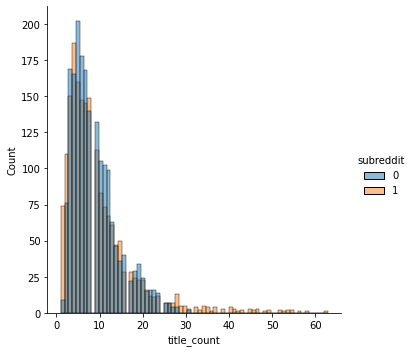

In [154]:
sns.displot(df_combined, x = 'title_count', hue = 'subreddit')


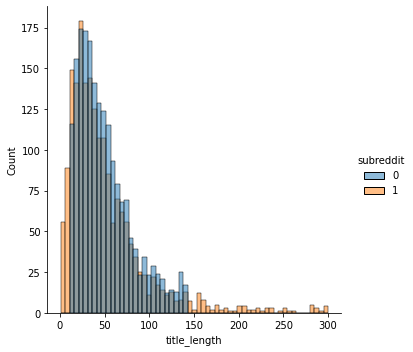

In [155]:
sns.displot(df_combined, x = 'title_length', hue = 'subreddit')

### Tokenizing, stemming and lemmatizing of text data

In [156]:
#Convert columns to string
df_combined['combined_text'] = df_combined['combined_text'].astype(str)
#Instantiate Tokenizer
tokenizer = RegexpTokenizer(r'\w+')
#Tokenize combined_text
df_combined['token_combined_text'] = df_combined['combined_text'].apply(tokenizer.tokenize)
#Instantiate lemmatizer
lemmatizer = WordNetLemmatizer()
#Lemmatize tokenized combined_text
df_combined['lem_combined_text'] = df_combined['token_combined_text'].apply(lambda x: [lemmatizer.lemmatize(i) for i in x])
#Instantiate stemmer
stemmer = PorterStemmer()
#Stem lemmatized combined_text
df_combined['stem_combined_text'] = df_combined['lem_combined_text'].apply(lambda x: [stemmer.stem(i) for i in x])

### Exploring CountVectorizer and TfidVectorizer

In [157]:
#Set stoplist with NLTK stopwords corpus
stoplist = stopwords.words('english')

In [158]:
#Define a function to get Count Vectorized DataFrame output of the dataframe
def CountVect(df, text_col, ngram_range, x, stoplist):
    cvec = CountVectorizer(stop_words = stoplist, ngram_range=ngram_range)
    vec_col = cvec.fit_transform(df[text_col])
    df_cvec = pd.DataFrame(vec_col.todense(), columns=cvec.get_feature_names_out())
    top_cvec = df_cvec.sum().sort_values(ascending=False).head(x)
    return top_cvec

In [159]:
#Define a function to get Count Vectorized DataFrame output of the dataframe
def TfidfVect(df, text_col, ngram_range, x,stoplist):
    tfidf = CountVectorizer(stop_words = stoplist, ngram_range=ngram_range)
    tfidf_col = tfidf.fit_transform(df[text_col])
    df_tfidf = pd.DataFrame(tfidf_col.todense(), columns=tfidf.get_feature_names_out())
    top_tfidf = df_tfidf.sum().sort_values(ascending=False).head(x)
    return top_tfidf

In [160]:
wsb = df_combined[df_combined['subreddit'] == 1]
stocks = df_combined[df_combined['subreddit'] == 0]

### CountVectorizer

In [161]:
#Get top 20 words from Wallstreetbets titles
wsb_top_words = CountVect(wsb, 'combined_text' , (1,1), 20, stoplist)
wsb_top_words_df = pd.DataFrame(wsb_top_words).reset_index()
wsb_top_words_df.columns = ['words', 'count']

In [162]:
#Get top 20 words from Stocks titles
stocks_top_words = CountVect(stocks, 'combined_text', (1,1), 20,stoplist)
stocks_top_words_df = pd.DataFrame(stocks_top_words).reset_index()
stocks_top_words_df.columns = ['words', 'count']

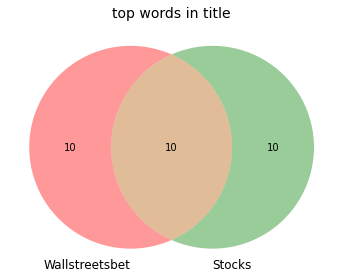

In [163]:
#Plot venn diagram of the words in the two different subreddit
venn2([set(wsb_top_words.index), set(stocks_top_words.index)], set_labels = ('Wallstreetsbet','Stocks'))
plt.title('top words in title', fontsize=14)
plt.tight_layout()

In [164]:
#Get list of common words
common_words = []

for i in range(len(wsb_top_words)):

    if wsb_top_words.index[i] in stocks_top_words.index:
        common_words.append(wsb_top_words.index[i])

common_words

['stock',
 'shares',
 'like',
 'company',
 'one',
 'market',
 'im',
 'time',
 'would',
 'price']

In [165]:
#Add additional common stop words to the stopwords corpus
stoplist = stopwords.words('english') + common_words

In [166]:
#Get top 20 words from Wallstreetbets titles (with additional stop words)
wsb_top_words = CountVect(wsb,'title', (1,1), 20, stoplist)
wsb_top_words_df = pd.DataFrame(wsb_top_words).reset_index()
wsb_top_words_df.columns = ['words', 'count']

In [167]:
#Get top 20 words from Stocks titles (with additional stop words)
stocks_top_words = CountVect(stocks, 'title', (1,1), 20, stoplist)
stocks_top_words_df = pd.DataFrame(stocks_top_words).reset_index()
stocks_top_words_df.columns = ['words', 'count']

In [168]:
#Define a function for creation of barplots to compare ngrams of the two subreddits
def plot_bar(df1,df2):
    #Set grid for charts
    fig, axes = plt.subplots(1,2,figsize = (25,10))

    #Plot chart for Wallstreetbets
    sns.barplot(
        data = df1, 
        x = df1['count'], 
        y = df1['words'], 
        ax = axes[0])

    axes[0].bar_label(axes[0].containers[0])
    axes[0].set_title('r/wallstreetbets')

    #Plot chart for Investing
    sns.barplot(
        data = df2, 
        x = df2['count'], 
        y = df2['words'], 
        ax = axes[1])

    axes[1].bar_label(axes[1].containers[0])
    axes[1].set_title('r/stocks')


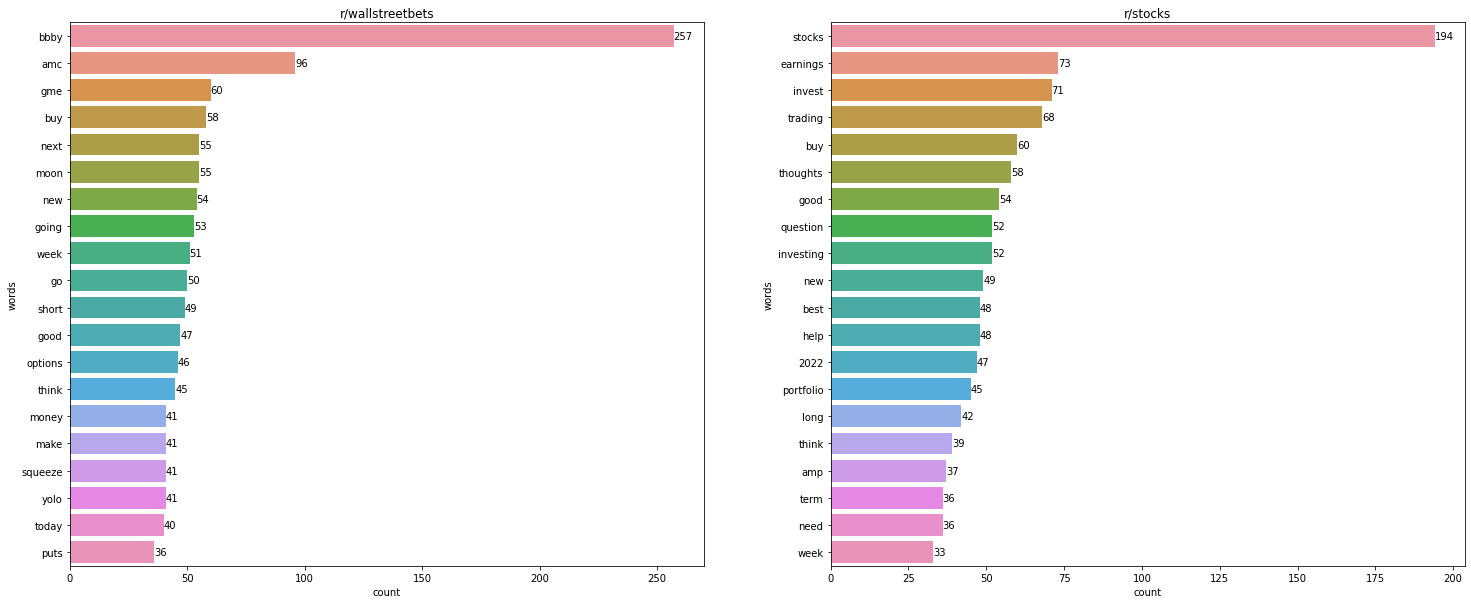

In [169]:
plot_bar(wsb_top_words_df,stocks_top_words_df)

In [170]:
#Get top 20 bigrams from Wallstreetbets
wsb_top_bigrams = CountVect(wsb, 'combined_text', (2,2), 20,stoplist)
wsb_top_bigrams_df = pd.DataFrame(wsb_top_bigrams).reset_index()
wsb_top_bigrams_df.columns = ['words', 'count']

In [171]:
#Get top 20 bigrams from Stocks
stocks_top_bigrams = CountVect(stocks, 'combined_text', (2,2), 20,stoplist)
stocks_top_bigrams_df = pd.DataFrame(stocks_top_bigrams).reset_index()
stocks_top_bigrams_df.columns = ['words', 'count']

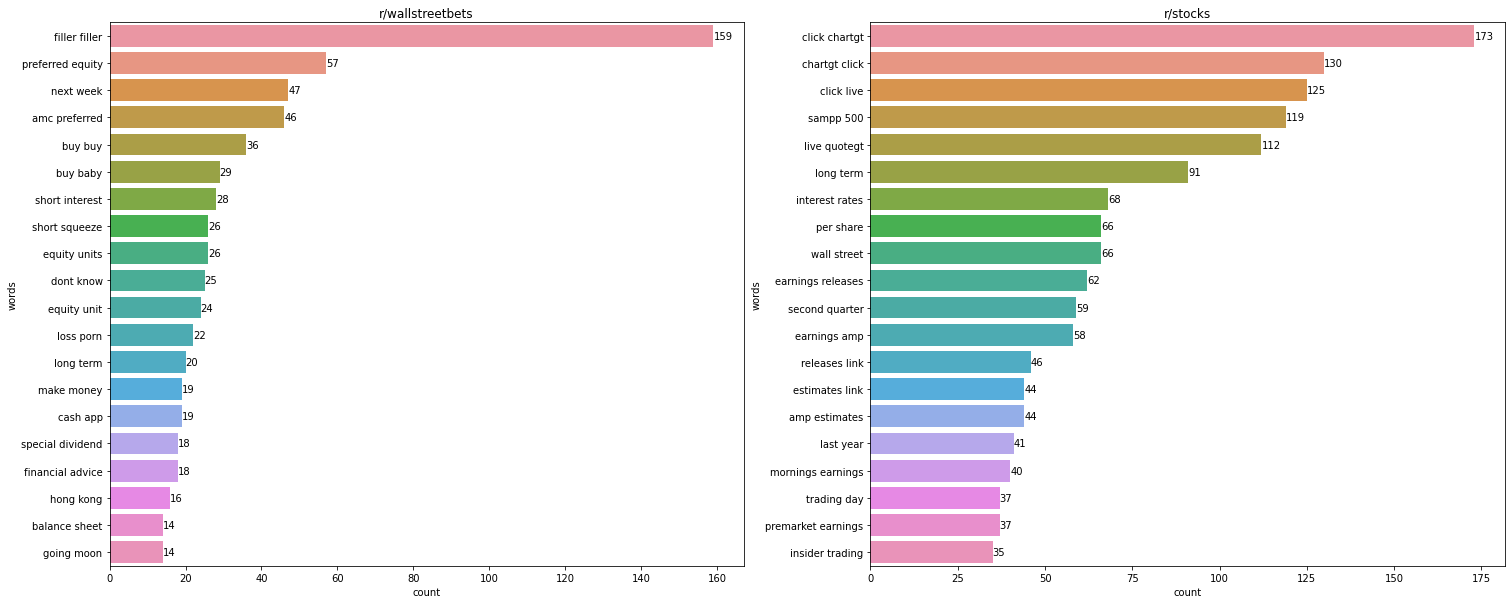

In [172]:
plot_bar(wsb_top_bigrams_df,stocks_top_bigrams_df)

### TfidVectorizer

In [174]:
#Define a function to get Count Vectorized DataFrame output of the dataframe
def TfidfVect(df, text_col, ngram_range, x,stoplist):
    tfidf = CountVectorizer(stop_words = stoplist, ngram_range=ngram_range)
    tfidf_col = tfidf.fit_transform(df[text_col])
    df_tfidf = pd.DataFrame(tfidf_col.todense(), columns=tfidf.get_feature_names_out())
    top_tfidf = df_tfidf.sum().sort_values(ascending=False).head(x)
    return top_tfidf

In [175]:
#Get top 20 words from Wallstreetbets
wsb_top_words = TfidfVect(wsb, 'combined_text', (1,1), 20, stoplist)
wsb_top_words_df = pd.DataFrame(wsb_top_words).reset_index()
wsb_top_words_df.columns = ['words', 'count']

In [176]:
#Get top 20 words from Stocks
stocks_top_words = TfidfVect(stocks, 'combined_text', (1,1), 20,stoplist)
stocks_top_words_df = pd.DataFrame(stocks_top_words).reset_index()
stocks_top_words_df.columns = ['words', 'count']

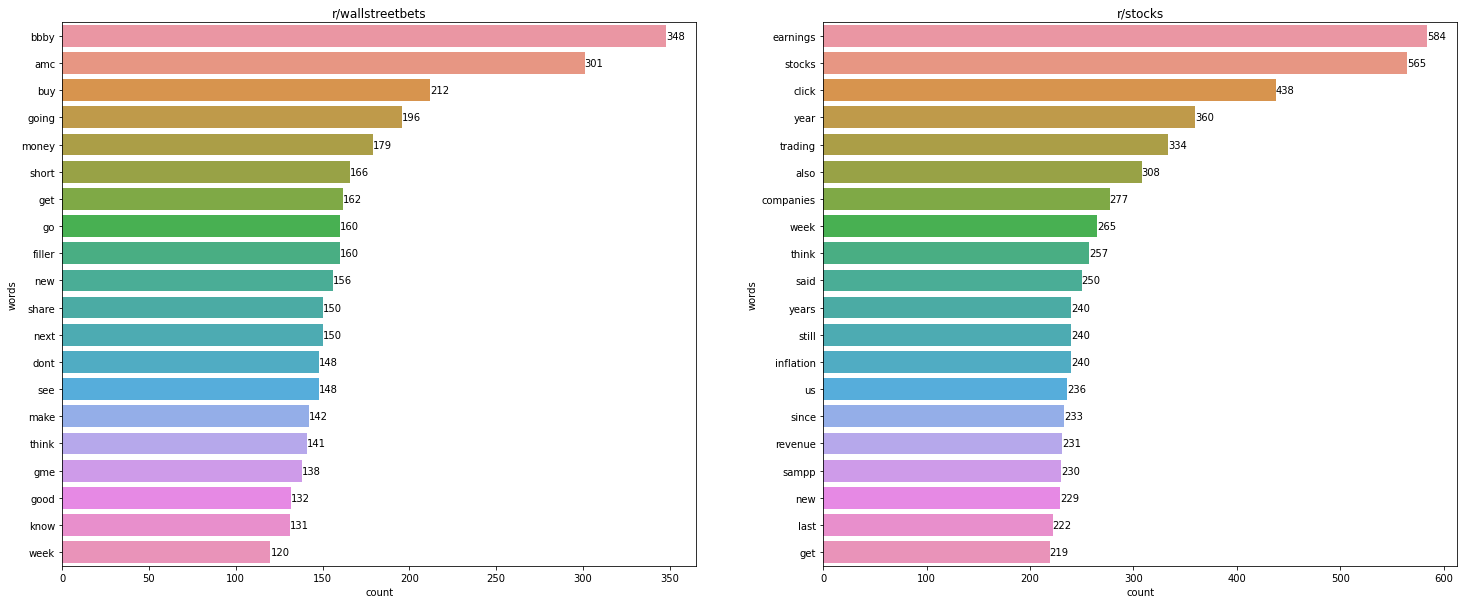

In [177]:
plot_bar(wsb_top_words_df,stocks_top_words_df)

In [178]:
#Get top 20 bigrams from Wallstreetbets
wsb_top_bigrams = TfidfVect(wsb, 'combined_text', (2,2), 20, stoplist)
wsb_top_bigrams_df = pd.DataFrame(wsb_top_bigrams).reset_index()
wsb_top_bigrams_df.columns = ['words', 'count']

In [179]:
#Get top 20 bigrams from Stocks
stocks_top_bigrams = TfidfVect(stocks, 'combined_text', (2,2), 20, stoplist)
stocks_top_bigrams_df = pd.DataFrame(stocks_top_bigrams).reset_index()
stocks_top_bigrams_df.columns = ['words', 'count']

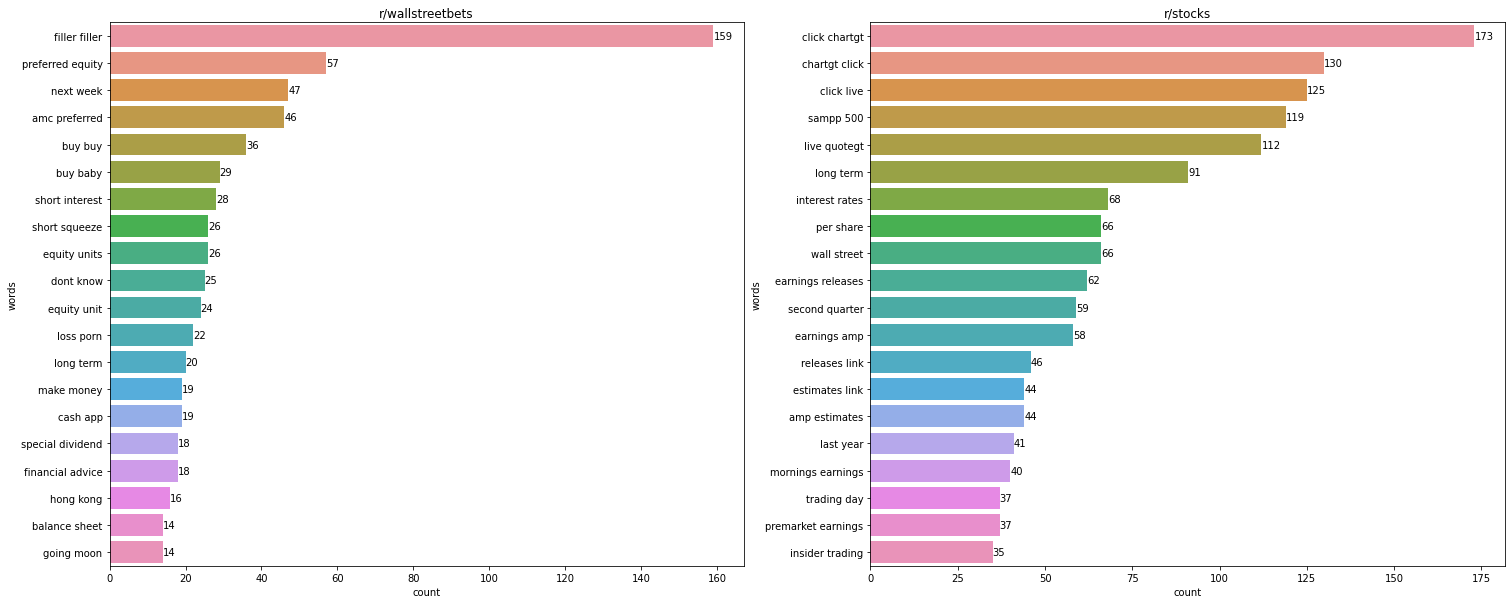

In [180]:
plot_bar(wsb_top_bigrams_df,stocks_top_bigrams_df)

In [181]:
df_combined.to_csv('data/combined_cleaned.csv')